In [1]:
%matplotlib notebook

# import modules
import random
import scipy.stats
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm
from pathlib import Path
import os
cwd = os.getcwd()
#import statsmodels.stats.moment_helpers
#from datetime import datetime
#import multiprocessing as mp
import csv
import networkx as nx
from IPython.display import HTML
from matplotlib import animation
import networkx as nx

# Setup

## Parameters

In [13]:
#if you fired on the LAST iter and go under target, decrease weights with stuff active on last step
#need a way to cancel out reinforcement of actions that lead to under-stimulation
# eg. fire -> turn away from stim -> don't fire -> decrease weights with stuff that fired
plotIter=360*2*20
nnodes=350
p_link=.05
leak=.1#
leaktype=1 #1 = leak a percentage, or 2 = leak a constant rate
lrate_wmat=.1
lrate_targ=.1
targ_min=1
sens_offset=30
movement_amp=1
input_amp=5
spike_cost = .1
stim_speed = 1
noise_sd = .1#1
weight_sd_init = 1
effector_type = 1
acts_neg=1

## Set up sensor nodes and input connections

In [14]:
sensory_nodes=[]
input_wmat=np.zeros((3,nnodes))
for row in range(input_wmat.shape[0]):
    for col in range(nnodes):
        input_wmat[row,col]=random.choices([0,input_amp], weights=(1-p_link,p_link), k=1)[0]
        if input_wmat[row,col] > 0:
            sensory_nodes.append(col)


In [15]:
len(sensory_nodes)

47

## Set up internal weight matrix

In [16]:
link_mat = np.zeros((nnodes,nnodes))
for row in range(link_mat.shape[0]):
    for col in range(link_mat.shape[1]):
        if row == col:
            continue
        link_mat[row,col] = random.choices([0,1], weights=(1-p_link,p_link), k=1)[0]
# link_mat[:,:]=1
# np.fill_diagonal(link_mat,0)
        
wmat=np.zeros((nnodes,nnodes))
for row in range(wmat.shape[0]):
    for col in range(wmat.shape[1]):
        if link_mat[row,col] == 1:
            wmat[row,col] = np.random.normal(0,weight_sd_init)
            
start_wmat=wmat.copy()

In [17]:
net = nx.from_numpy_matrix(wmat)
#nx.draw_networkx(net, arrows=True,width=.1,with_labels=False, node_size=5, pos = nx.shell_layout(net))
layout = nx.spring_layout(net)

In [18]:
effector_nodes=[]
if effector_type ==1:
    output_wmat=np.zeros((nnodes,2))
    for row in range(output_wmat.shape[0]):
        for col in range(output_wmat.shape[1]):
            output_wmat[row,col]=random.choices([0,1], weights=(1-p_link,p_link), k=1)[0]
            if output_wmat[row,col] > 0:
                effector_nodes.append(row)

    while len(list(set(sensory_nodes) & set(effector_nodes))) > 0:
        effector_nodes=[]
        output_wmat=np.zeros((nnodes,2))
        for row in range(output_wmat.shape[0]):
            for col in range(output_wmat.shape[1]):
                output_wmat[row,col]=random.choices([0,1], weights=(1-p_link,p_link), k=1)[0]
                if output_wmat[row,col] > 0:
                    effector_nodes.append(row)
else:       
    #select two random nodes to be output nodes
    effector_nodes = random.sample(range(1, nnodes), 2)
    while len(list(set(sensory_nodes) & set(effector_nodes))) > 0:
        effector_nodes = random.sample(range(1, nnodes), 2)



In [19]:
len(effector_nodes)

26

In [20]:
list(set(sensory_nodes) & set(effector_nodes))

[]

## Functions

In [21]:
def get_plot_vals(degree, heading):
    x = np.cos(np.radians(degree))
    y = np.sin(np.radians(degree))
    
    sLdeg = heading + sens_offset
    if sLdeg > 360:
        sLdeg = sLdeg - 360
    sCdeg = heading
    sRdeg = heading - sens_offset
    if sRdeg < 0:
        sRdeg = 360 + sRdeg
        
    sLx = .5*np.cos(np.radians(sLdeg)) 
    sLy = .5*np.sin(np.radians(sLdeg)) 
    sLpos = np.array([sLx,sLy])
    
    sCx = .5*np.cos(np.radians(heading)) 
    sCy = .5*np.sin(np.radians(heading)) 
    sCpos = np.array([sCx,sCy])
    
    sRx = .5*np.cos(np.radians(sRdeg)) 
    sRy = .5*np.sin(np.radians(sRdeg))
    sRpos = np.array([sRx, sRy])
    
    return x, y, sLx, sLy, sCx, sCy, sRx, sRy

def move_stim(degree, direction):
    if direction == 1:
        degree += stim_speed
    else:
        degree -= stim_speed
        
    if degree > 360:
        degree = degree - 360
    if degree < 0:
        degree = degree + 360

    return degree

def rotate_agent(output_acts, heading):
    diff = (output_acts[0] - output_acts[1])*movement_amp
    #diff = (output_spikes[0] - output_spikes[1])*movement_amp
    heading = heading + diff
    
    if heading > 360:
        heading = heading - 360
    if heading < 0:
        heading = heading + 360
    
    return heading

def get_input_acts(heading, degree):
    
    sLdeg = heading + sens_offset
    if sLdeg > 360:
        sLdeg = sLdeg - 360
    if sLdeg <0:
        sLdeg = sLdeg + 360
        
    dL = np.abs(degree - sLdeg)
    if dL > 180:
        dL = 360 - dL
        
    dC = np.abs(degree - heading)
    if dC >180:
        dC = 360 - 180
        
    sRdeg = heading - sens_offset
    if sRdeg > 360:
        sRdeg = sRdeg - 360
    if sRdeg < 0:
        sRdeg = sRdeg + 360
        
    dR = np.abs(degree - sRdeg)
    if dR > 180:
        dR = 360 - dR
    
#     sL_act = 1-dL/180
#     sR_act = 1-dR/180
    
    if dL <= 60:
        sL_act = 1 - dL/60
    else:
        sL_act = 0
        
    if dC <= 60:
        sC_act = 1 - dC/60
    else:
        sC_act = 0
    
    if dR <= 60:
        sR_act = 1 - dR/60
    else:
        sR_act = 0
        
    return [sL_act, sC_act, sR_act], [dL, dC, dR]

def get_acts(acts,leak,spikes,wmat,input,input_wmat,targets, spike_rep):
    
    thresholds = targets*2
    
    if leaktype == 1:
        acts = acts*(1-leak) + np.dot(input, input_wmat) + np.dot(spikes, wmat) + np.random.normal(0,noise_sd,size=nnodes)
    else:
        acts = acts-leak + np.dot(input, input_wmat) + np.dot(spikes, wmat) + np.random.normal(0,noise_sd,size=nnodes)

    spikes[acts >= thresholds]=1
    spikes[acts < thresholds]=0
    
    # new stuff 
    if spike_cost>0:
        spike_rep[spikes==1]+=1
    #     spike_rep[spikes==0]-=1
        spike_rep[spikes==0]=0
    #     spike_rep[spike_rep<0]=0
        spikes[spikes==1] -= (1-np.exp(-spike_rep[spikes==1]*spike_cost))
    
    acts[spikes>0]=acts[spikes>0]-thresholds[spikes>0]
    
    # setting negative acts back to 0 before accounting for errors seems important for tracking behavior - why?
    if acts_neg == 0:
        acts[acts<0]=0
        
    errors=acts-targets
    
    return acts, spikes, errors, spike_rep

def learning(learn_on,link_mat,spikes,prev_spikes, errors,wmat,targets):
    
    active_neighbors=link_mat.copy()
    active_neighbors[prev_spikes==0,:]=0
    d_wmat = active_neighbors.copy()
    active_neighbors=np.sum(active_neighbors,axis=0)#+np.repeat(1,nnodes)
    
    if learn_on==1:
        if np.sum(active_neighbors) >0:
            #d_wmat = np.zeros((nnodes,nnodes))
            #d_wmat[:,:]=errors*lrate_wmat
            d_wmat = errors*d_wmat
            #d_wmat[link_mat==0]=0
            #d_wmat[prev_inactive,:]=0
            d_wmat=(d_wmat/active_neighbors)
            d_wmat=np.nan_to_num(d_wmat)
            wmat-=d_wmat
            
        #should this update every time, or only when active_neighbors >0
        targets=targets+(errors*lrate_targ) # could multiply by acts, so that this value naturally can't go below 0? but that will also amplify the change when acts are very high
        targets[targets<targ_min]=targ_min
        #targets[spikes==1]=targets[spikes==1]+(errors[spikes==1]*lrate_targ) # could multiply by acts, so that this value naturally can't go below 0? but that will also amplify the change when acts are very high
            
        
    return wmat, targets



# Run the model

<IPython.core.display.Javascript object>


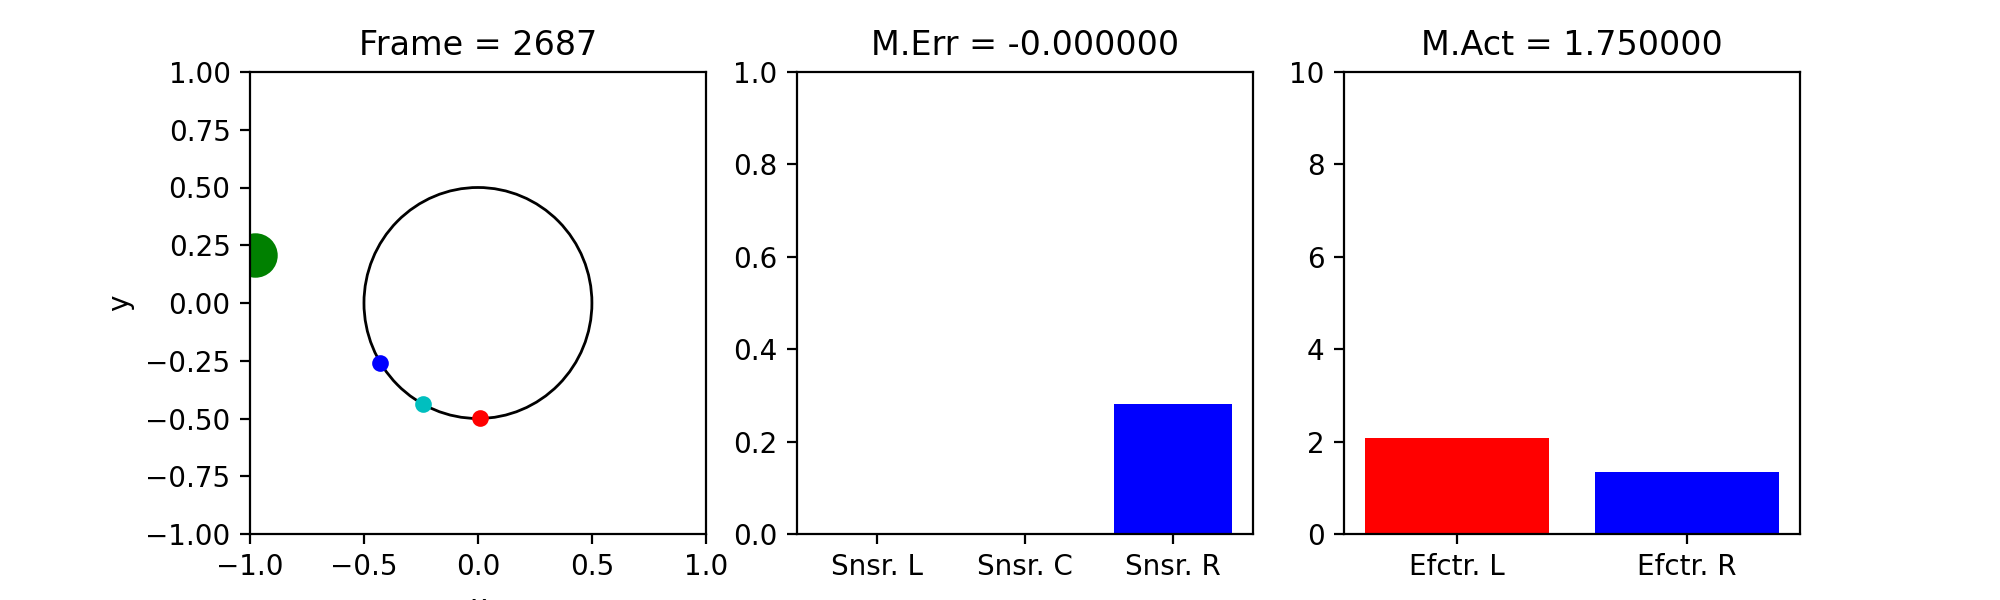

In [22]:
spikes=np.zeros(nnodes)
spike_rep=np.zeros(nnodes)
targets=np.repeat(targ_min,nnodes)
acts=np.zeros(nnodes)
input_acts = np.zeros(3)
output_acts = np.zeros(2)
# output_spikes = np.zeros(2)
# output_targets = np.repeat(targ_min,2)
MeanAbsErs=[]
MeanActs =[]
MeanSpikes=[]

i=1
degree = 0
heading = 180
direction = 1
learn_on=1
def drawframe(n):
    global noise_sd,link_decay,spike_rep,direction,degree, heading, acts, input_acts, output_acts, leak, spikes, prev_spikes, wmat, input_wmat, output_wmat, targets, errors,MeanAbsErs,MeanActs,MeanSpikes
    
    #if (n %  1440 == 0) and (n !=0):
    if n == (plotIter/2):
        if direction == 1:
            direction = 2
        else:
            direction = 1
    
    input, dists = get_input_acts(heading, degree)
        
    prev_spikes = spikes.copy()
    
    acts, spikes, errors,spike_rep = get_acts(acts,leak,spikes,wmat,input,input_wmat,targets,spike_rep)
    if effector_type == 1:
        output_acts = np.dot(spikes, output_wmat)
    else:
        output_acts = acts[effector_nodes]
        
    wmat, targets = learning(learn_on,link_mat,spikes,prev_spikes, errors, wmat,targets)
    
    x, y, sLx, sLy, sCx, sCy, sRx, sRy = get_plot_vals(degree, heading)
    
    degree = move_stim(degree, direction)
    heading = rotate_agent(output_acts, heading)
    
    txt_title1.set_text('Frame = {0:4d}'.format(n))
    txt_title2.set_text('M.Err = {0:f}'.format(np.round(np.mean(errors), decimals=2)))
    txt_title3.set_text('M.Act = {0:f}'.format(np.round(np.mean(acts), decimals=2)))

    pt1.set_data(x,y)
    sL.set_data(sLx,sLy)
    sC.set_data(sCx,sCy)
    sR.set_data(sRx,sRy)
    bar1_plt2.set_height(input[0])
    bar2_plt2.set_height(input[1])
    bar3_plt2.set_height(input[2])
    bar1_plt3.set_height(output_acts[0])
    bar2_plt3.set_height(output_acts[1])
    
#     ax4.clear()
#     netfig=nx.draw_networkx(net,width=.1,with_labels=False, node_size=10, pos = layout, node_color=spikes)
#     bar1_plt5.set_height(np.mean(np.abs(acts)))
#     bar2_plt5.set_height(np.mean(np.abs(errors)))
#     bar3_plt5.set_height(np.mean(targets))
#     ax6.clear()
#     ax6.set_ylim((0,150))
#     ax6.set_xlim((-5,5))
#     ax6.hist(x=np.matrix.flatten(wmat[link_mat==1]), bins='auto', alpha=0.7, rwidth=0.85)
    
    
    if (n % 100 !=0):
        MeanAbsEr = np.mean(np.abs(errors))
        MeanAbsErs.append(MeanAbsEr)
        MeanAct = np.mean(acts)
        MeanActs.append(MeanAct)
        MeanSpike = np.mean(spikes)
        MeanSpikes.append(MeanSpike)
        #print('iteration: ', n, ' ; MeanAbsEr: ',MeanAbsEr, ' ; MeanAct: ', MeanAct)
    else:
        MeanAbsEr = np.mean(np.abs(errors))
        MeanAbsErs.append(MeanAbsEr)
        MeanAct = np.mean(acts)
        MeanActs.append(MeanAct)
        MeanSpike = np.mean(spikes)
        MeanSpikes.append(MeanSpike)
        
        MeanAbsErs_ = np.round(np.mean(MeanAbsErs),decimals=2)
        MeanActs_ = np.round(np.mean(MeanActs),decimals=2)
        MeanSpikes_ = np.round(np.mean(MeanSpikes),decimals=2)
        print('iteration: ', str(n), ' ; MeanAbsErs: ',str(MeanAbsErs_), ' ; MeanAct: ', str(MeanActs_), '; MeanSpikes: ', str(MeanSpikes_))
        MeanAbsErs=[]
        MeanActs=[]
        MeanSpikes=[]
    
    #txt_title2.set_text('MnAbsEr: ' + str(np.mean(np.abs(errors))) + ' ; MnAct: ' + str(np.mean(acts)) + '; MnSpk: ', str(np.mean(spikes)))
    #txt_title2.set_text('MnAbsEr = {0:4d}'.format(np.mean(np.abs(errors))))
    #txt_title2.set_text('iteration: ' + str(n))
    return (pt1,sL,sC, sR)

# create a figure and axes
#fig = plt.figure(figsize=(12,8))
fig = plt.figure(figsize=(10,3))
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)

#ax4 = plt.subplot(2,3,4)
#ax5 = plt.subplot(2,3,5)
#ax6 = plt.subplot(2,3,6)

# set up the subplots as needed
ax1.set_xlim(( -1, 1))            
ax1.set_ylim((-1, 1))
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax2.set_ylim((0, 1))
ax3.set_ylim((0, 10))


# ax5.set_ylim((0,3))
# ax6.set_ylim((0,150))
# ax6.set_xlim((-5,5))

circle1 = plt.Circle((0, 0), 0.5, color='black', fill = 0)
ax1.add_patch(circle1)

# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.

pt1, = ax1.plot([], [], 'g.', ms=30)
sL, = ax1.plot([],[], 'r.', ms =10)
sC, = ax1.plot([],[],'c.',ms=10)
sR, = ax1.plot([],[], 'b.', ms =10)
bar1_plt2, bar2_plt2, bar3_plt2 = ax2.bar(['Snsr. L', 'Snsr. C', 'Snsr. R'],[0,0,0], color = ['r','c','b'])
bar1_plt3, bar2_plt3 = ax3.bar(['Efctr. L', 'Efctr. R'],[0,0], color = ['r','b'])


# plt.sca(ax4)
# netfig = nx.draw_networkx(net,width=.1,with_labels=False, node_size=10, pos = layout, node_color=spikes)
#bar1_plt5, bar2_plt5, bar3_plt5 = ax5.bar(['MAct','MErr', 'MTarget'],[0,0,0],color = 'black')
#ax6.hist(x=np.matrix.flatten(wmat[link_mat==1]), bins='auto',alpha=0.7, rwidth=0.85)

txt_title1 = ax1.set_title('')
txt_title2 = ax2.set_title('')
txt_title3 = ax3.set_title('')
# txt_title6 = ax6.set_title('Weight Dist.')

spikes=np.zeros(nnodes)
targets=np.repeat(targ_min,nnodes)
acts=np.zeros(nnodes)
input_acts = np.zeros(2)
output_acts = np.zeros(2)
# output_spikes = np.zeros(2)
# output_targets = np.repeat(targ_min,2)
MeanAbsErs=[]
MeanActs =[]
MeanSpikes = []

In [23]:
anim = animation.FuncAnimation(fig, drawframe, frames=plotIter, interval=20, blit=True)
#plt.show()
anim.save('MV_RotatingAgent_3Sensors_X.mp4') #v1

iteration:  0  ; MeanAbsErs:  0.99  ; MeanAct:  0.01 ; MeanSpikes:  0.0
iteration:  0  ; MeanAbsErs:  0.99  ; MeanAct:  0.01 ; MeanSpikes:  0.0


/Users/jbenfalandays/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:142: RuntimeWarning: invalid value encountered in true_divide


iteration:  100  ; MeanAbsErs:  1.0  ; MeanAct:  0.0 ; MeanSpikes:  0.0
iteration:  200  ; MeanAbsErs:  0.89  ; MeanAct:  1.37 ; MeanSpikes:  0.35
iteration:  300  ; MeanAbsErs:  0.77  ; MeanAct:  1.48 ; MeanSpikes:  0.3
iteration:  400  ; MeanAbsErs:  0.71  ; MeanAct:  1.53 ; MeanSpikes:  0.25
iteration:  500  ; MeanAbsErs:  0.68  ; MeanAct:  1.59 ; MeanSpikes:  0.22
iteration:  600  ; MeanAbsErs:  0.66  ; MeanAct:  1.57 ; MeanSpikes:  0.22
iteration:  700  ; MeanAbsErs:  0.65  ; MeanAct:  1.59 ; MeanSpikes:  0.21
iteration:  800  ; MeanAbsErs:  0.67  ; MeanAct:  1.64 ; MeanSpikes:  0.21
iteration:  900  ; MeanAbsErs:  0.64  ; MeanAct:  1.63 ; MeanSpikes:  0.19
iteration:  1000  ; MeanAbsErs:  0.66  ; MeanAct:  1.64 ; MeanSpikes:  0.19
iteration:  1100  ; MeanAbsErs:  0.65  ; MeanAct:  1.6 ; MeanSpikes:  0.2
iteration:  1200  ; MeanAbsErs:  0.69  ; MeanAct:  1.66 ; MeanSpikes:  0.2
iteration:  1300  ; MeanAbsErs:  0.69  ; MeanAct:  1.66 ; MeanSpikes:  0.23
iteration:  1400  ; MeanAbsE

iteration:  11000  ; MeanAbsErs:  0.64  ; MeanAct:  1.8 ; MeanSpikes:  0.17
iteration:  11100  ; MeanAbsErs:  0.67  ; MeanAct:  1.83 ; MeanSpikes:  0.18
iteration:  11200  ; MeanAbsErs:  0.73  ; MeanAct:  1.84 ; MeanSpikes:  0.2
iteration:  11300  ; MeanAbsErs:  0.7  ; MeanAct:  1.82 ; MeanSpikes:  0.19
iteration:  11400  ; MeanAbsErs:  0.68  ; MeanAct:  1.79 ; MeanSpikes:  0.17
iteration:  11500  ; MeanAbsErs:  0.68  ; MeanAct:  1.76 ; MeanSpikes:  0.19
iteration:  11600  ; MeanAbsErs:  0.7  ; MeanAct:  1.75 ; MeanSpikes:  0.2
iteration:  11700  ; MeanAbsErs:  0.7  ; MeanAct:  1.77 ; MeanSpikes:  0.21
iteration:  11800  ; MeanAbsErs:  0.69  ; MeanAct:  1.76 ; MeanSpikes:  0.2
iteration:  11900  ; MeanAbsErs:  0.68  ; MeanAct:  1.77 ; MeanSpikes:  0.18
iteration:  12000  ; MeanAbsErs:  0.68  ; MeanAct:  1.8 ; MeanSpikes:  0.18
iteration:  12100  ; MeanAbsErs:  0.7  ; MeanAct:  1.73 ; MeanSpikes:  0.18
iteration:  12200  ; MeanAbsErs:  0.7  ; MeanAct:  1.75 ; MeanSpikes:  0.2
iteration:

In [ ]:
### alternate way to plot

In [ ]:
#HTML(anim.to_html5_video())